# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Skip this part if you run on the CPU (recommended)

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [1]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

IndexError: list index out of range

# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on. Lets pretend that everyone is using an Nvidia RTX 3090 graphics card.

Question 1: Google the name of the graphics card, how many CUDA cores does it have?

Question 2: How much memory does the graphics card have?

Question 3: What is stored in the GPU memory while training a DNN ?

In [2]:
"""
Q1. 10496 CUDA cores

Q2. 24 GB

Q3. Input data, weights, and outputs of hidden layers (activations).
"""

'\nQ1. 10496 CUDA cores\n\nQ2. 24 GB\n\nQ3. Input data, weights, and outputs of hidden layers (activations).\n'

# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. (not recommended, unless you want to learn how to do it)

We will use the function `genfromtxt` to load the data. (not recommended, unless you want to learn how to do it)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.


In [3]:
from numpy import genfromtxt # Not needed if you load data from numpy arrays
import numpy as np

# Load data from numpy arrays, choose reduced files if the training takes too long
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')

# Remove the first 24 covariates (columns)
X = X[:, 24:]

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
print(f"Number of examples of each class: {np.unique(Y, return_counts = True)}")

The covariates have size (764137, 92).
The labels have size (764137,).
Number of examples of each class: (array([0., 1.]), array([121621, 642516], dtype=int64))


# Part 5: How good is a naive classifier?

Question 4: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

In [4]:
print(f"a naive classifier will have an accuracy of : {np.unique(Y, return_counts = True)[1][1]  / np.unique(Y, return_counts = True)[1].sum()}")

a naive classifier will have an accuracy of : 0.8408387501194158


In [5]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()

# Print the number of NaNs (not a number) in the labels
print(np.isnan(Y).sum())

# Print the number of NaNs in the covariates
print(np.isnan(X).sum())

0
0


# Part 6: Preprocessing

Lets do some simple preprocessing

In [6]:
# Convert covariates to floats
X = X.astype("float")

# Convert labels to integers
Y = Y.astype("int")

# Remove mean of each covariate (column)
X = X - X.mean(axis = 0)

# Divide each covariate (column) by its standard deviation
X = X / X.std(axis = 0)

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print(X.mean(axis = 0))
print(X.std(axis = 0))

[-3.19451533e-18 -6.32970181e-14  1.19926356e-13  4.56743018e-15
  4.10210037e-14  1.46130975e-13  5.85246484e-16 -1.69734859e-14
 -3.36915700e-13  1.28688437e-12 -2.69360995e-12 -1.10733213e-13
 -1.22392702e-13 -1.70649630e-13 -1.02461166e-14  2.50701280e-12
  1.47553162e-12  1.08446837e-12 -1.04981959e-13  6.83458762e-14
 -1.03373555e-13  5.98825773e-14 -1.02025960e-12 -1.68983055e-12
 -1.79101143e-12 -1.31828514e-13  4.42580403e-13  6.14635580e-13
  5.78048199e-14 -4.92623328e-13 -2.54513072e-12  1.86544900e-13
 -1.53444593e-13  1.68079591e-12  9.30041709e-13  1.50738177e-13
 -1.15688852e-12 -3.62610361e-13 -1.71390937e-12 -2.09264067e-13
  1.07161976e-12 -1.45236885e-12 -1.69724579e-14 -1.64918984e-16
 -5.13444996e-14 -1.02171349e-14 -1.74685907e-15  1.34264921e-13
  5.98801969e-14  1.48745574e-17 -4.25442340e-13  5.78079594e-14
  1.25638129e-15  1.69449684e-13  1.50725881e-13  2.14439542e-14
  3.65457183e-14  1.17260451e-13 -8.82752870e-13 -6.34816648e-13
 -1.62109649e-12  2.63270

# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [7]:
from sklearn.model_selection import train_test_split

# Your code
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, test_size = .3)

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
print(f"Number of examples of each class in training data: {np.unique(Ytrain, return_counts = True)}")
print(f"Number of examples of each class in remaining data: {np.unique(Ytemp, return_counts = True)}")

Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).
Number of examples of each class in training data: (array([0, 1]), array([ 85334, 449561], dtype=int64))
Number of examples of each class in remaining data: (array([0, 1]), array([ 36287, 192955], dtype=int64))


#  Part 8: Split non-training data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [11]:
Xval, Xtest, Yval, Ytest= train_test_split(Xtemp, Ytemp, test_size = .5)

print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114621, 92), (114621, 92), (114621,) and (114621,)


# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


In [108]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from keras.losses import BinaryCrossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False, dropout_rate = 0.5):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == 'sgd' :
        opt = SGD(learning_rate = learning_rate)
    elif optimizer == 'adam' :
        opt = Adam(learning_rate = learning_rate)
    elif optimizer == 'rmsprop' :
        opt = RMSprop(learning_rate = learning_rate)
    
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, input_shape = input_shape, activation = act_fun))
    if use_dropout == True :
        model.add(Dropout(rate = dropout_rate))
    elif use_custom_dropout == True :
        model.add(myDropout(rate = dropout_rate))
    if use_bn == True :
        model.add(BatchNormalization())
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation = act_fun))
        if use_dropout == True :
            model.add(Dropout(rate = dropout_rate))
        elif use_custom_dropout == True :
            model.add(myDropout(rate = dropout_rate))
        if use_bn == True:
            model.add(BatchNormalization())

    
    # Add final layer
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Compile model
    model.compile(optimizer = opt, loss = BinaryCrossentropy(), metrics = ['accuracy'])
    
    return model

In [9]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


### 2 layers, 20 nodes

In [12]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = (X.shape[1],)

# Build the model
model1 = build_DNN(input_shape, 2, 20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=False, use_dropout=False,
                   use_custom_dropout=False)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain, Ytrain, batch_size, epochs, validation_data = (Xval, Yval))

Epoch 1/20
54/54 [==============================] - 1s 13ms/step - loss: 0.4269 - accuracy: 0.8405 - val_loss: 0.4013 - val_accuracy: 0.8403
Epoch 2/20
54/54 [==============================] - 0s 8ms/step - loss: 0.3815 - accuracy: 0.8405 - val_loss: 0.3589 - val_accuracy: 0.8403
Epoch 3/20
54/54 [==============================] - 0s 7ms/step - loss: 0.3329 - accuracy: 0.8405 - val_loss: 0.3056 - val_accuracy: 0.8403
Epoch 4/20
54/54 [==============================] - 0s 8ms/step - loss: 0.2803 - accuracy: 0.8404 - val_loss: 0.2574 - val_accuracy: 0.8402
Epoch 5/20
54/54 [==============================] - 0s 7ms/step - loss: 0.2401 - accuracy: 0.8508 - val_loss: 0.2266 - val_accuracy: 0.8596
Epoch 6/20
54/54 [==============================] - 0s 8ms/step - loss: 0.2166 - accuracy: 0.8749 - val_loss: 0.2099 - val_accuracy: 0.8888
Epoch 7/20
54/54 [==============================] - 0s 8ms/step - loss: 0.2039 - accuracy: 0.8976 - val_loss: 0.2007 - val_accuracy: 0.9002
Epoch 8/20
54/54 [=

In [13]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 3s 914us/step - loss: 0.1732 - accuracy: 0.9070
Test loss: 0.1732
Test accuracy: 0.9070


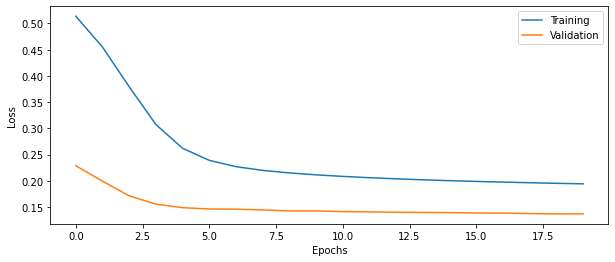

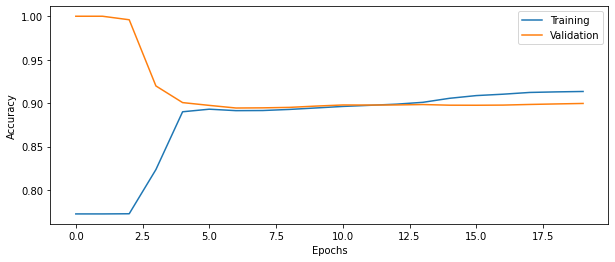

In [14]:
# Plot the history from the training run
plot_results(history1)

# Part 11: More questions

Question 5: What happens if you add several Dense layers without specifying the activation function?

Question 6: How are the weights in each dense layer initialized as default? How are the bias weights initialized?


In [14]:
"""
Q5. Adding dense layers without specifying the activation function results in default linear activation.

Q6. Default initialization of weights in Dense layers is glorot_uniform which assigns weights randomly according to a uniform distribution,
whose limits depend on the number of input and output units of the layer.
Bias weights are initialized with zeros by default.
"""

'\nQ5. Adding dense layers without specifying the activation function results in default linear activation.\n\nQ6. Default initialization of weights in Dense layers is glorot_uniform which assigns weights randomly according to a uniform distribution,\nwhose limits depend on the number of input and output units of the layer.\nBias weights are initialized with zeros by default.\n'

# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

You need to call the function something like this

class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )

otherwise it will complain

In [19]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(Y), y = Y)

# Print the class weights
print(class_weights)
# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights, 
# or get them from the array that is returned from class_weight

class_weights = {0: class_weights[0],
                 1: class_weights[1]}


[3.14146817 0.59464434]


### 2 layers, 20 nodes, class weights

In [16]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model2 = build_DNN(input_shape, 2, 20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=False, use_dropout=False,
                   use_custom_dropout=False)

history2 = model2.fit(Xtrain, Ytrain, batch_size, epochs, validation_data = (Xval, Yval), class_weight = class_weights)

Epoch 1/20
54/54 [==============================] - 1s 15ms/step - loss: 0.6348 - accuracy: 0.8730 - val_loss: 0.5679 - val_accuracy: 0.8802
Epoch 2/20
54/54 [==============================] - 1s 15ms/step - loss: 0.4891 - accuracy: 0.8809 - val_loss: 0.4183 - val_accuracy: 0.8792
Epoch 3/20
54/54 [==============================] - 0s 9ms/step - loss: 0.3425 - accuracy: 0.8803 - val_loss: 0.3210 - val_accuracy: 0.8794
Epoch 4/20
54/54 [==============================] - 0s 8ms/step - loss: 0.2677 - accuracy: 0.8804 - val_loss: 0.2891 - val_accuracy: 0.8795
Epoch 5/20
54/54 [==============================] - 0s 9ms/step - loss: 0.2390 - accuracy: 0.8806 - val_loss: 0.2775 - val_accuracy: 0.8796
Epoch 6/20
54/54 [==============================] - 1s 9ms/step - loss: 0.2262 - accuracy: 0.8808 - val_loss: 0.2715 - val_accuracy: 0.8798
Epoch 7/20
54/54 [==============================] - 0s 7ms/step - loss: 0.2190 - accuracy: 0.8811 - val_loss: 0.2662 - val_accuracy: 0.8806
Epoch 8/20
54/54 [

In [20]:
# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 3s 897us/step - loss: 0.2375 - accuracy: 0.8999
Test loss: 0.2375
Test accuracy: 0.8999


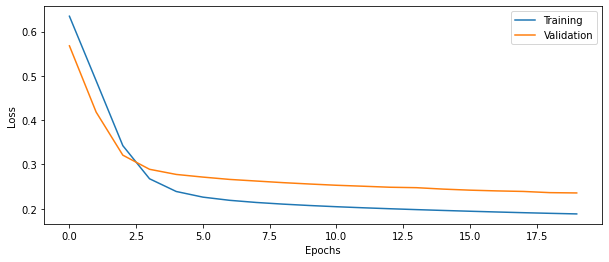

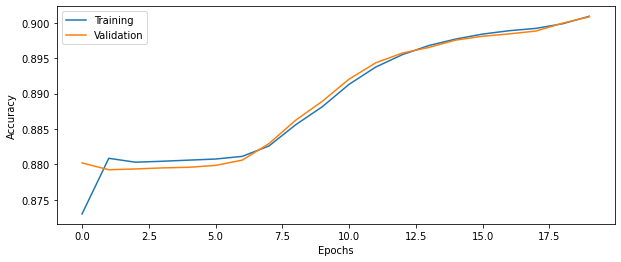

In [21]:
plot_results(history2)

# Part 13: More questions

Skip questions 8 and 9 if you run on the CPU (recommended)

Question 7: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

Question 8: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the computer a few times during training.

Question 9: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

Question 10: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

Question 11: What limits how large the batch size can be?

Question 12: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

In [67]:
"""
Q7. Batch size is required to split the training data into batches that can be loaded in the memory or the
GPU, otherwise if the data set is too large, the entire training data will not fit into the memory.

Q10. Size of training data is 534895 in our case, so the number of iterations will be :

batch size = 100: 534895/100 = 5348.95 = 5349
batch size = 1000: 534895/1000 = 534.895 = 535
batch size = 10000: 534895/10000 = 53.4895 = 54

and in each iteration the weights will be updated.

Q11. The memory size will limit the batch size.

Q12. If we decrease the batch size, the learning rate should also be decreased to account for more
iterations, and also the greater irregularity, and smaller amount of information contained in smaller
batches.
"""

'\nQ7. Batch size is required to split the training data into batches that can be loaded in the memory or the\nGPU, otherwise if the data set is too large, the entire training data will not fit into the memory.\n\nQ10. Size of training data is 534895 in our case, so the number of iterations will be :\n\nbatch size = 100: 534895/100 = 5348.95 = 5349\nbatch size = 1000: 534895/1000 = 534.895 = 535\nbatch size = 10000: 534895/10000 = 53.4895 = 54\n\nand in each iteration the weights will be updated.\n\nQ11. The memory size will limit the batch size.\n\nQ12. If we decrease the batch size, the learning rate should also be decreased to account for more\niterations, and also the greater irregularity, and smaller amount of information contained in smaller\nbatches.\n'

# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 13: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

In [35]:
model2.summary()
model5.summary()

"""
No of trainable parameters for 2 layers, 20 nodes each: 2,301
No of trainable parameters for 4 layers, 50 nodes each: 12,351
"""

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                1860      
                                                                 
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dense_8 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,301
Trainable params: 2,301
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 50)                4650      
                                                                 
 dense_18 (Dense)            (

'\nNo of trainable parameters for 2 layers, 20 nodes each: 2,301\nNo of trainable parameters for 4 layers, 50 nodes each: 12,351\n'

### 4 layers, 20 nodes, class weights

In [25]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model3 = build_DNN(input_shape, 4, 20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=False, use_dropout=False,
                   use_custom_dropout=False)

history3 = model3.fit(Xtrain, Ytrain, batch_size, epochs, validation_data = (Xval, Yval), class_weight = class_weights)

Epoch 1/20
54/54 [==============================] - 3s 19ms/step - loss: 0.7013 - accuracy: 0.4881 - val_loss: 0.7002 - val_accuracy: 0.1597
Epoch 2/20
54/54 [==============================] - 1s 12ms/step - loss: 0.6945 - accuracy: 0.2666 - val_loss: 0.6975 - val_accuracy: 0.1597
Epoch 3/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6941 - accuracy: 0.2713 - val_loss: 0.6938 - val_accuracy: 0.1442
Epoch 4/20
54/54 [==============================] - 0s 9ms/step - loss: 0.6938 - accuracy: 0.3544 - val_loss: 0.6988 - val_accuracy: 0.1597
Epoch 5/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6935 - accuracy: 0.3067 - val_loss: 0.6949 - val_accuracy: 0.1598
Epoch 6/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6931 - accuracy: 0.3294 - val_loss: 0.6953 - val_accuracy: 0.1597
Epoch 7/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6927 - accuracy: 0.3528 - val_loss: 0.6920 - val_accuracy: 0.8806
Epoch 8/20
54/

In [26]:
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 3s 939us/step - loss: 0.6561 - accuracy: 0.8801
Test loss: 0.6561
Test accuracy: 0.8801


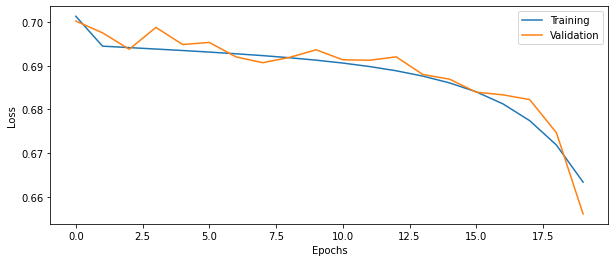

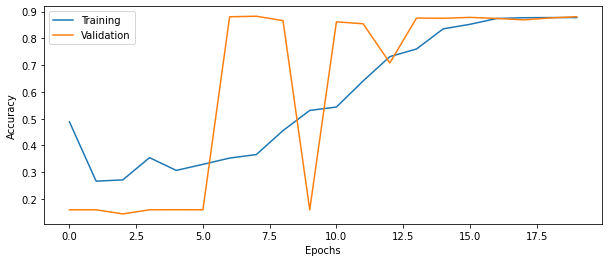

In [27]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [28]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model4 = build_DNN(input_shape, 2, 50, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=False, use_dropout=False,
                   use_custom_dropout=False)

history4 = model4.fit(Xtrain, Ytrain, batch_size, epochs, validation_data = (Xval, Yval), class_weight = class_weights)

Epoch 1/20
54/54 [==============================] - 1s 17ms/step - loss: 0.6125 - accuracy: 0.8207 - val_loss: 0.5123 - val_accuracy: 0.8879
Epoch 2/20
54/54 [==============================] - 1s 14ms/step - loss: 0.4085 - accuracy: 0.8862 - val_loss: 0.3409 - val_accuracy: 0.8845
Epoch 3/20
54/54 [==============================] - 1s 15ms/step - loss: 0.2749 - accuracy: 0.8856 - val_loss: 0.2852 - val_accuracy: 0.8857
Epoch 4/20
54/54 [==============================] - 1s 14ms/step - loss: 0.2338 - accuracy: 0.8879 - val_loss: 0.2698 - val_accuracy: 0.8887
Epoch 5/20
54/54 [==============================] - 1s 14ms/step - loss: 0.2191 - accuracy: 0.8905 - val_loss: 0.2628 - val_accuracy: 0.8906
Epoch 6/20
54/54 [==============================] - 1s 16ms/step - loss: 0.2112 - accuracy: 0.8924 - val_loss: 0.2577 - val_accuracy: 0.8932
Epoch 7/20
54/54 [==============================] - 1s 15ms/step - loss: 0.2061 - accuracy: 0.8948 - val_loss: 0.2525 - val_accuracy: 0.8950
Epoch 8/20
54

In [29]:
# Evaluate model on test data
score = model4.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 4s 993us/step - loss: 0.2338 - accuracy: 0.9021
Test loss: 0.2338
Test accuracy: 0.9021


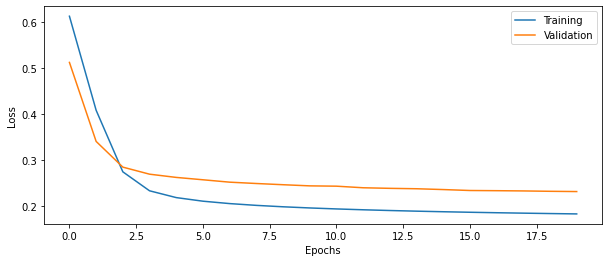

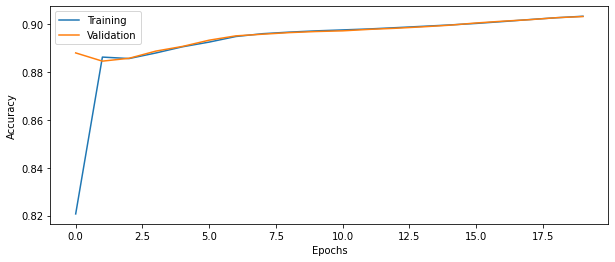

In [30]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [31]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model5 = build_DNN(input_shape, 4, 50, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=False, use_dropout=False,
                   use_custom_dropout=False)

history5 = model5.fit(Xtrain, Ytrain, batch_size, epochs, validation_data = (Xval, Yval), class_weight = class_weights)

Epoch 1/20
54/54 [==============================] - 2s 27ms/step - loss: 0.7006 - accuracy: 0.5525 - val_loss: 0.6934 - val_accuracy: 0.1942
Epoch 2/20
54/54 [==============================] - 1s 24ms/step - loss: 0.6911 - accuracy: 0.5732 - val_loss: 0.6895 - val_accuracy: 0.8793
Epoch 3/20
54/54 [==============================] - 1s 22ms/step - loss: 0.6899 - accuracy: 0.6739 - val_loss: 0.6942 - val_accuracy: 0.1598
Epoch 4/20
54/54 [==============================] - 1s 23ms/step - loss: 0.6885 - accuracy: 0.7033 - val_loss: 0.7026 - val_accuracy: 0.1597
Epoch 5/20
54/54 [==============================] - 1s 22ms/step - loss: 0.6866 - accuracy: 0.7253 - val_loss: 0.6782 - val_accuracy: 0.8633
Epoch 6/20
54/54 [==============================] - 1s 22ms/step - loss: 0.6839 - accuracy: 0.8428 - val_loss: 0.6804 - val_accuracy: 0.8827
Epoch 7/20
54/54 [==============================] - 1s 22ms/step - loss: 0.6801 - accuracy: 0.8766 - val_loss: 0.6807 - val_accuracy: 0.8795
Epoch 8/20
54

In [32]:
# Evaluate model on test data
score = model5.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 4s 1ms/step - loss: 0.2553 - accuracy: 0.8917
Test loss: 0.2553
Test accuracy: 0.8917


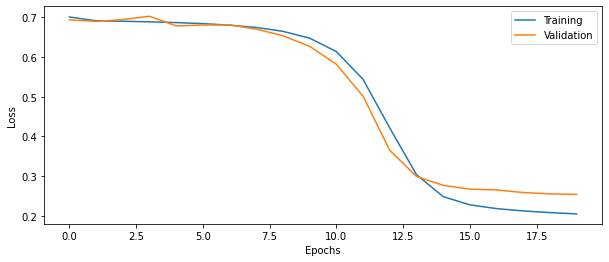

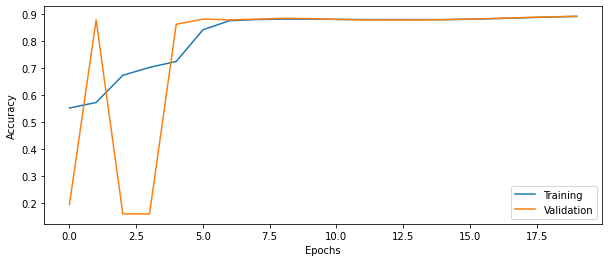

In [33]:
plot_results(history5)

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 14: Why is batch normalization important when training deep networks?

In [36]:
"""
Using batch normalization speeds up the training of deep networks because without batch normalization, the
inputs of the subsequent layers can be impacted more resulting in variation in the gradients that can cause
opposing learning parameters.
"""

'\nUsing batch normalization speeds up the training of deep networks because without batch normalization, the\ninputs of the subsequent layers can be impacted more resulting in variation in the gradients that can cause\nopposing learning parameters.\n'

### 2 layers, 20 nodes, class weights, batch normalization

In [37]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model6 = build_DNN(input_shape, 2, 20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=True, use_dropout=False,
                   use_custom_dropout=False)

history6 = model6.fit(Xtrain, Ytrain, batch_size, epochs, validation_data = (Xval, Yval), class_weight = class_weights)

Epoch 1/20
54/54 [==============================] - 1s 14ms/step - loss: 0.2981 - accuracy: 0.8805 - val_loss: 0.4205 - val_accuracy: 0.8403
Epoch 2/20
54/54 [==============================] - 1s 11ms/step - loss: 0.2103 - accuracy: 0.9048 - val_loss: 0.3465 - val_accuracy: 0.8403
Epoch 3/20
54/54 [==============================] - 1s 12ms/step - loss: 0.1946 - accuracy: 0.9088 - val_loss: 0.2946 - val_accuracy: 0.8404
Epoch 4/20
54/54 [==============================] - 1s 12ms/step - loss: 0.1871 - accuracy: 0.9107 - val_loss: 0.2412 - val_accuracy: 0.8485
Epoch 5/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1824 - accuracy: 0.9122 - val_loss: 0.1997 - val_accuracy: 0.8813
Epoch 6/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1791 - accuracy: 0.9131 - val_loss: 0.1804 - val_accuracy: 0.9125
Epoch 7/20
54/54 [==============================] - 1s 12ms/step - loss: 0.1767 - accuracy: 0.9137 - val_loss: 0.1809 - val_accuracy: 0.9148
Epoch 8/20
54

In [38]:
# Evaluate model on test data
score = model6.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 4s 1ms/step - loss: 0.2074 - accuracy: 0.9149
Test loss: 0.2074
Test accuracy: 0.9149


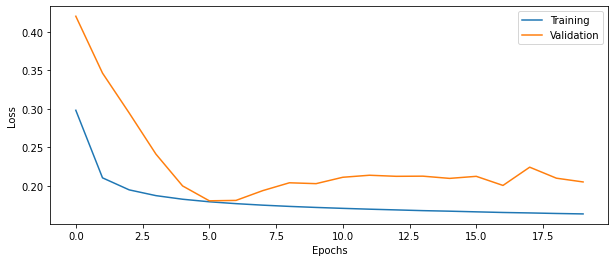

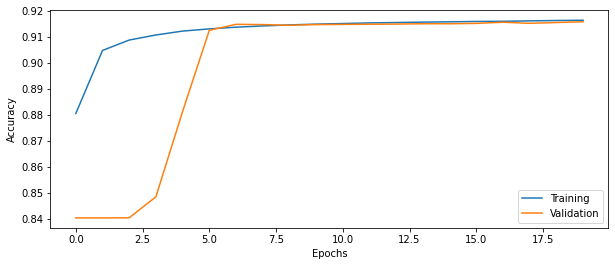

In [39]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [40]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model7 = build_DNN(input_shape, 2, 20, act_fun='relu', optimizer='sgd', learning_rate=0.1, use_bn=False, use_dropout=False,
                   use_custom_dropout=False)

history7 = model7.fit(Xtrain, Ytrain, batch_size, epochs, validation_data = (Xval, Yval), class_weight = class_weights)

Epoch 1/20
54/54 [==============================] - 1s 11ms/step - loss: 0.3370 - accuracy: 0.8567 - val_loss: 0.2794 - val_accuracy: 0.8790
Epoch 2/20
54/54 [==============================] - 1s 10ms/step - loss: 0.2085 - accuracy: 0.8826 - val_loss: 0.2547 - val_accuracy: 0.8850
Epoch 3/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1958 - accuracy: 0.8892 - val_loss: 0.2470 - val_accuracy: 0.8920
Epoch 4/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1900 - accuracy: 0.8954 - val_loss: 0.2402 - val_accuracy: 0.8975
Epoch 5/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1861 - accuracy: 0.8989 - val_loss: 0.2366 - val_accuracy: 0.9004
Epoch 6/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1830 - accuracy: 0.9034 - val_loss: 0.2356 - val_accuracy: 0.9040
Epoch 7/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1804 - accuracy: 0.9050 - val_loss: 0.2276 - val_accuracy: 0.9056
Epoch 8/20
54/54 [

In [41]:
# Evaluate model on test data
score = model7.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 3s 942us/step - loss: 0.2118 - accuracy: 0.9145
Test loss: 0.2118
Test accuracy: 0.9145


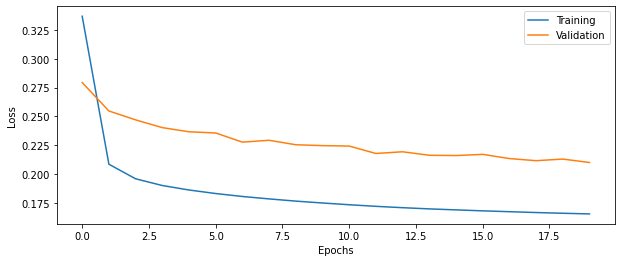

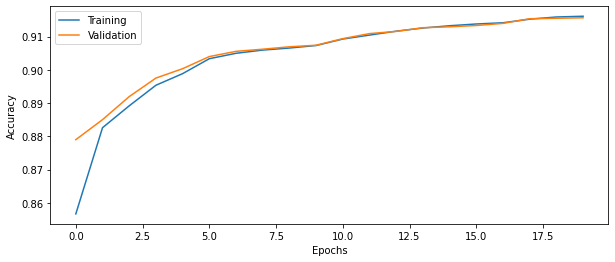

In [42]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [43]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model8 = build_DNN(input_shape, 2, 20, act_fun='sigmoid', optimizer='adam', learning_rate=0.1, use_bn=False, use_dropout=False,
                   use_custom_dropout=False)

history8 = model8.fit(Xtrain, Ytrain, batch_size, epochs, validation_data = (Xval, Yval), class_weight = class_weights)

Epoch 1/20
54/54 [==============================] - 1s 10ms/step - loss: 0.2234 - accuracy: 0.8881 - val_loss: 0.2212 - val_accuracy: 0.9141
Epoch 2/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1677 - accuracy: 0.9162 - val_loss: 0.2119 - val_accuracy: 0.9168
Epoch 3/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1637 - accuracy: 0.9181 - val_loss: 0.2122 - val_accuracy: 0.9187
Epoch 4/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1605 - accuracy: 0.9197 - val_loss: 0.2039 - val_accuracy: 0.9192
Epoch 5/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1591 - accuracy: 0.9202 - val_loss: 0.1982 - val_accuracy: 0.9200
Epoch 6/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1557 - accuracy: 0.9210 - val_loss: 0.1987 - val_accuracy: 0.9205
Epoch 7/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1537 - accuracy: 0.9209 - val_loss: 0.1993 - val_accuracy: 0.9200
Epoch 8/20
54/54 [=

In [44]:
# Evaluate model on test data
score = model8.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 3s 907us/step - loss: 0.2118 - accuracy: 0.9211
Test loss: 0.2118
Test accuracy: 0.9211


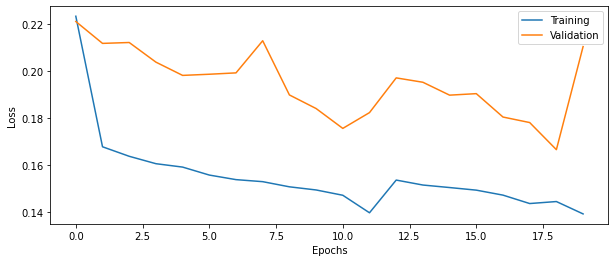

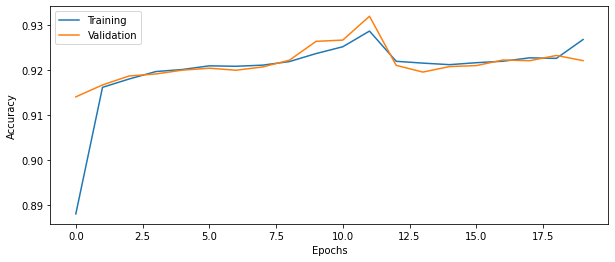

In [45]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. 

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 15: How does the validation accuracy change when adding dropout?

Question 16: How does the test accuracy change when adding dropout?

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [49]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model9 = build_DNN(input_shape, 2, 20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=False, use_dropout=True,
                   use_custom_dropout=False)

history9 = model9.fit(Xtrain, Ytrain, batch_size, epochs, validation_data = (Xval, Yval), class_weight = class_weights)

Epoch 1/20
54/54 [==============================] - 1s 14ms/step - loss: 0.6924 - accuracy: 0.5838 - val_loss: 0.6035 - val_accuracy: 0.8768
Epoch 2/20
54/54 [==============================] - 1s 11ms/step - loss: 0.6145 - accuracy: 0.6713 - val_loss: 0.5243 - val_accuracy: 0.8788
Epoch 3/20
54/54 [==============================] - 1s 11ms/step - loss: 0.5378 - accuracy: 0.7481 - val_loss: 0.4304 - val_accuracy: 0.8785
Epoch 4/20
54/54 [==============================] - 1s 12ms/step - loss: 0.4677 - accuracy: 0.7926 - val_loss: 0.3597 - val_accuracy: 0.8785
Epoch 5/20
54/54 [==============================] - 1s 11ms/step - loss: 0.4122 - accuracy: 0.8205 - val_loss: 0.3187 - val_accuracy: 0.8786
Epoch 6/20
54/54 [==============================] - 1s 11ms/step - loss: 0.3748 - accuracy: 0.8363 - val_loss: 0.2982 - val_accuracy: 0.8788
Epoch 7/20
54/54 [==============================] - 1s 11ms/step - loss: 0.3482 - accuracy: 0.8466 - val_loss: 0.2889 - val_accuracy: 0.8788
Epoch 8/20
54

In [50]:
# Evaluate model on test data
score = model9.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 4s 1ms/step - loss: 0.2728 - accuracy: 0.8782
Test loss: 0.2728
Test accuracy: 0.8782


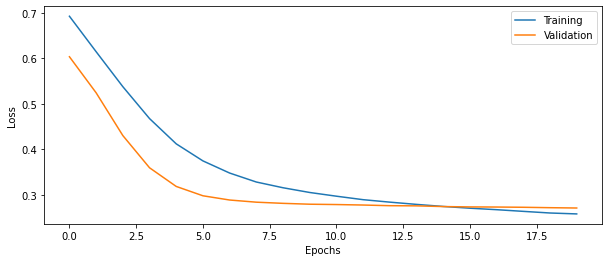

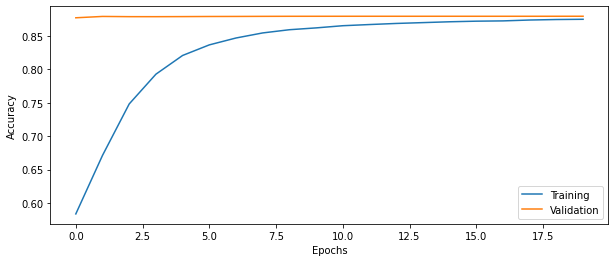

In [51]:
plot_results(history9)

In [53]:
"""
Q15. 
Validation accuracy without dropout: 0.9008
Validation accuracy with dropout: 0.8791

Q16.
Test accuracy without dropout: 0.8999
Test accuracy with dropout: 0.8782
"""

'\nQ15. \nValidation accuracy without dropout: 0.9008\nValidation accuracy with dropout: 0.8791\n\nQ16.\nTest accuracy without dropout: 0.8999\nTest accuracy with dropout: 0.8782\n'

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 17: How high classification accuracy can you achieve for the test data? What is your best configuration?

In [105]:
# Find your best configuration for the DNN
batch_size = 5000
epochs = 30
input_shape = (X.shape[1],)

# Build and train DNN
model10 = build_DNN(input_shape, 5, 30, act_fun='relu', optimizer='rmsprop', learning_rate=0.05, use_bn=True, use_dropout=False,
                   use_custom_dropout=False)

history10 = model10.fit(Xtrain, Ytrain, batch_size, epochs, validation_data = (Xval, Yval), class_weight = class_weights)


Epoch 1/30
107/107 [==============================] - 4s 20ms/step - loss: 0.2186 - accuracy: 0.8999 - val_loss: 0.9381 - val_accuracy: 0.9025
Epoch 2/30
107/107 [==============================] - 2s 19ms/step - loss: 0.1747 - accuracy: 0.9143 - val_loss: 1.2211 - val_accuracy: 0.8996
Epoch 3/30
107/107 [==============================] - 2s 18ms/step - loss: 0.1655 - accuracy: 0.9168 - val_loss: 1.1369 - val_accuracy: 0.9135
Epoch 4/30
107/107 [==============================] - 2s 19ms/step - loss: 0.1609 - accuracy: 0.9185 - val_loss: 0.4018 - val_accuracy: 0.9156
Epoch 5/30
107/107 [==============================] - 2s 18ms/step - loss: 0.1558 - accuracy: 0.9202 - val_loss: 0.2264 - val_accuracy: 0.9183
Epoch 6/30
107/107 [==============================] - 2s 17ms/step - loss: 0.1518 - accuracy: 0.9215 - val_loss: 0.3866 - val_accuracy: 0.9173
Epoch 7/30
107/107 [==============================] - 2s 18ms/step - loss: 0.1472 - accuracy: 0.9247 - val_loss: 0.4825 - val_accuracy: 0.9162

In [106]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 4s 1ms/step - loss: 0.1993 - accuracy: 0.9348
Test loss: 0.1993
Test accuracy: 0.9348


# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 18: What is the mean and the standard deviation of the test accuracy?

In [107]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [109]:
# Your best training parameters
batch_size = 5000
epochs = 30
input_shape = (X.shape[1],)

# Build and train model
model11 = build_DNN(input_shape, 5, 30, act_fun='relu', optimizer='rmsprop', learning_rate=0.05, use_bn=True, use_dropout=False,
                   use_custom_dropout=True)

history11 = model11.fit(Xtrain, Ytrain, batch_size, epochs, validation_data = (Xval, Yval), class_weight = class_weights)

Epoch 1/30
107/107 [==============================] - 5s 26ms/step - loss: 0.2476 - accuracy: 0.8871 - val_loss: 0.6800 - val_accuracy: 0.9026
Epoch 2/30
107/107 [==============================] - 3s 24ms/step - loss: 0.2025 - accuracy: 0.9040 - val_loss: 0.9207 - val_accuracy: 0.5898
Epoch 3/30
107/107 [==============================] - 3s 24ms/step - loss: 0.1979 - accuracy: 0.9063 - val_loss: 0.2917 - val_accuracy: 0.9034
Epoch 4/30
107/107 [==============================] - 3s 24ms/step - loss: 0.1976 - accuracy: 0.9060 - val_loss: 0.2110 - val_accuracy: 0.9084
Epoch 5/30
107/107 [==============================] - 3s 25ms/step - loss: 0.1944 - accuracy: 0.9072 - val_loss: 0.2096 - val_accuracy: 0.9084
Epoch 6/30
107/107 [==============================] - 3s 26ms/step - loss: 0.1945 - accuracy: 0.9069 - val_loss: 0.2053 - val_accuracy: 0.9081
Epoch 7/30
107/107 [==============================] - 3s 25ms/step - loss: 0.1943 - accuracy: 0.9071 - val_loss: 0.1898 - val_accuracy: 0.9079

In [115]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest, Ytest)
                       
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 5s 1ms/step - loss: 0.2697 - accuracy: 0.9076
Test accuracy: 0.9076


In [123]:
# Run the testing 100 times, and save the accuracies in an array
test_scores = np.ndarray(100)
for i in range(100) :
    test_scores[i] = model11.evaluate(Xtest, Ytest)[1]

# Calculate and print mean and std of accuracies
print(f"mean of test accuracy: {np.mean(test_scores)}")
print(f"standard deviation of test accuracy: {np.std(test_scores)}")

3582/3582 [==============================] - 5s 1ms/step - loss: 0.2681 - accuracy: 0.9076
0.907744915485382
0.00023779375777612446


In [125]:
print(f"mean is : {np.mean(test_scores)}", )

mean is : 0.907744915485382


# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 19: What is the mean and the standard deviation of the test accuracy?

Question 20: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.

In [132]:
from sklearn.model_selection import StratifiedKFold

test_accuracy = np.ndarray(10)
# Define 10-fold cross validation
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1234)

# Loop over cross validation folds
for train_index, test_index in skf.split(X, Y) :
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    # Calculate class weights for current split
    class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(Y_train), y = Y_train)
    # Rebuild the DNN model, to not continue training on the previously trained model
    CVmodel = build_DNN(input_shape, 5, 30, act_fun='relu', optimizer='rmsprop', learning_rate=0.05, use_bn=True, use_dropout=False,
                   use_custom_dropout=False)
    # Fit the model with training set and class weights for this fold
    CVmodel.fit(X_train, Y_train, batch_size, epochs, class_weight = class_weights)
    # Evaluate the model using the test set for this fold
    score = CVmodel.evaluate(X_test, Y_test)
    # Save the test accuracy in an array
    np.append(test_accuracy, score)
# Calculate and print mean and std of accuracies
print(f"mean of test accuracy: {np.mean(test_accuracy)}")
print(f"standard deviation of test accuracy: {np.std(test_accuracy)}")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [128]:
"""
Q19.

Q20. Advantage of using dropout for estimating test uncertainty is that we do not need to retrain the model every time for calculating the test
accuracy. In contrast, using CV we need to train the model on every iteration of CV, which will take a long time, especially if the number of folds is
large, or the model takes a long time to train.
"""

'\nQ19.\n\nQ20. Advantage of using dropout for estimating test uncertainty is that we do not need to retrain the model every time for calculating the test\naccuracy. In contrast, using CV we need to train the model on every iteration of CV, which will take a long time, especially if the number of folds is\nlarge, or the model takes a long time to train.\n'

# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 21: How would you change the DNN in order to use it for regression instead?

## Report

Send in this jupyter notebook, with answers to all questions.